In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import torch
from torch_geometric.data import Data
from helpers_functions import *
from gymnasium import spaces
from gerry_environment import FrankenmanderingEnv
from graph_initiator import build_init_data
# from report_gen import plot_summary_each_run,pairwise_hamming_mean, plot_summary_global
from mcmc_commit import mcmc_full_annealing

In [4]:
init_data, G_graph = build_init_data()

num_voters = init_data.opinion.shape[0]
num_districts = 4
target_opinion=[7]*num_voters

env_sco = FrankenmanderingEnv(num_voters=num_voters,
                          num_districts=num_districts,
                          opinion_dim=1,
                          FrankenData=init_data,
                          target_opinion=target_opinion)
env_sco.reset()
initial_opinion = init_data.opinion

df_summary,env, ensemble_labels, ensemble_rewards,ensemble_opinions, acceptance_rates, global_accept_rate = mcmc_full_annealing(
    env =env_sco ,
    outer_loops = 100,
    hot_steps = 20,
    anneal_steps =80,
    cold_steps = 20,
    T_init = 1,
    T_final = 0.01,
    seed = 42,
    drf = drf_inchworm_withso,
    beta1 = 0.1,
    beta2 = 0.5,
    p_keep = 0.5
)

BA (undirected) edges: 140 (expected m*(N-m) = 2*(72-2) = 140)
SOC directed arcs: 280 (should be 2 * 140 = 280)
[Outer step 1/100] best reward = -0.3953, inner acceptance rate = 0.400
[Outer step 2/100] best reward = -0.3953, inner acceptance rate = 0.317
[Outer step 3/100] best reward = -0.3687, inner acceptance rate = 0.358
[Outer step 4/100] best reward = -0.7733, inner acceptance rate = 0.308
[Outer step 5/100] best reward = -0.1748, inner acceptance rate = 0.833
[Outer step 6/100] best reward = 0.0681, inner acceptance rate = 0.442
[Outer step 7/100] best reward = -1.0497, inner acceptance rate = 0.175
[Outer step 8/100] best reward = -0.3919, inner acceptance rate = 0.167
[Outer step 9/100] best reward = -0.6330, inner acceptance rate = 0.117
[Outer step 10/100] best reward = 0.0364, inner acceptance rate = 0.192
[Outer step 11/100] best reward = -0.1194, inner acceptance rate = 0.167
[Outer step 12/100] best reward = -0.2747, inner acceptance rate = 0.142
[Outer step 13/100] bes

In [5]:
df_summary.to_csv('output.csv', index=False)

In [6]:
def reward_improvement(df):
    """Return mean improvement from min to best reward."""
    improvement = df['reward_best'] - df['reward_best'].min()
    return improvement.mean(), improvement.std()

In [7]:
def mean_opinion_change(df):
    """Return mean and std of opinion change magnitude."""
    delta = df['last_mean_opinin'] - df['initial_mean_opinin']
    return delta.mean(), delta.std()

In [9]:
def dist_from_initial(df):
    """Euclidean distance per step between initial and best opinions (per-agent)."""
    distances = []
    for _, row in df.iterrows():
        init_op = np.array(initial_opinion)
        best_op = np.array(row['best_opinion'])
        d = np.linalg.norm(best_op - init_op)
        distances.append(d)
    return np.mean(distances), np.std(distances)

In [10]:
def calc_best_reward(df):
    """Return the maximum best reward achieved across all runs."""
    return df['reward_best'].max()


In [11]:
def mean_change_each_step(df):
    """Mean absolute per-agent change from initial to best opinion per step."""
    changes = []
    for _, row in df.iterrows():
        init_op = np.array(initial_opinion)
        best_op = np.array(row['best_opinion'])
        diff = np.abs(best_op - init_op)
        changes.append(np.mean(diff))
    return np.mean(changes), np.std(changes)

In [13]:
def summarize_mcmc_results(df):
    summary = {}
    # summary['acceptance_rate'] = df['accepted_step_rate'].mean()
    summary['opinion_change_mean'], summary['opinion_change_std'] = mean_opinion_change(df)
    summary['dist_from_initial_mean'], summary['dist_from_initial_std'] = dist_from_initial(df)
    summary['best_reward'] = calc_best_reward(df)
    summary['mean_reward'] = df['reward_best'].mean()
    summary['mean_shift_step'] = mean_change_each_step(df)

    return summary

In [14]:
summary = summarize_mcmc_results(df_summary)
print("=== GLOBAL MCMC SUMMARY ===")
for key, val in summary.items():
    print(f"{key:30s}: {val:.4f}" if isinstance(val, (float, np.floating)) else f"{key:30s}: {val}")

=== GLOBAL MCMC SUMMARY ===
opinion_change_mean           : 1.7034
opinion_change_std            : 0.3868
dist_from_initial_mean        : 181.9347
dist_from_initial_std         : 16.8347
best_reward                   : 0.0681
mean_reward                   : -1.0425
mean_shift_step               : (np.float64(2.07873474319431), np.float64(0.19386093747558122))


In [15]:
import matplotlib.pyplot as plt

def plot_grouped_opinion_bar(opinions_sequence, title="Opinion Distribution per Run"):
    """
    Plot all opinions per run as grouped bars.

    :param title: chart title
    """
    num_runs = len(opinions_sequence)
    num_ops = opinions_sequence[0].shape[0]

    # Flatten vector opinions to scalar by averaging if needed
    opinions_flat = [op.mean(axis=1) if op.ndim > 1 else op for op in opinions_sequence]

    # Prepare data for grouped bars
    x = np.arange(num_runs)  # runs on x-axis
    width = 0.8 / num_ops  # width of each bar within group

    plt.figure(figsize=(max(8, num_runs), 5))

    for i in range(num_ops):
        agent_values = [opinions_flat[run][i] for run in range(num_runs)]
        plt.bar(x + i*width, agent_values, width=width, label="")

    plt.xlabel("Run")
    plt.ylabel("Opinion Value")
    plt.title(title)
    plt.xticks(x + width*(num_ops-1)/2, [f"Run {i+1}" for i in range(num_runs)])
    plt.legend()
    plt.show()


In [16]:
# save_path = "/content/drive/My Drive/scale_test"

/tmp/ipython-input-455693182.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


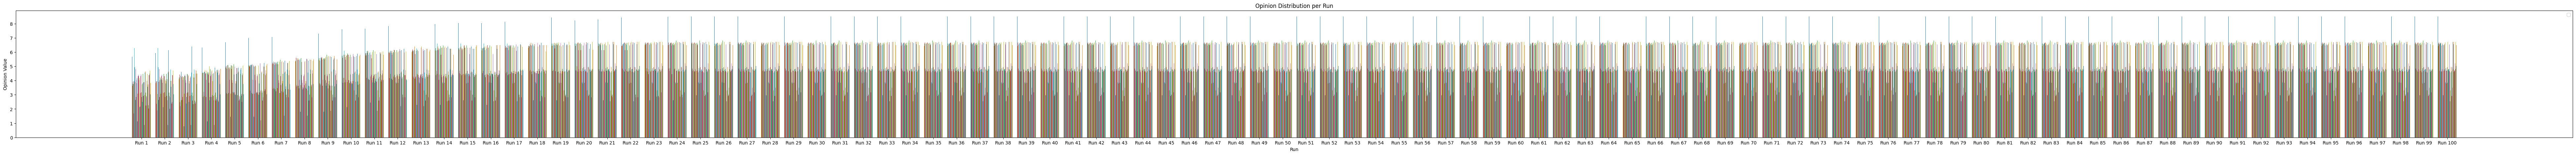

In [17]:

# Plot histograms
plot_grouped_opinion_bar(ensemble_opinions)


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def plot_stacked_bar(df, step_col, opinion_col, opinion_range):
    grouped = df.groupby(step_col)[opinion_col].sum()  # concatenates lists
    counts = []
    for step, opinions in grouped.items():
        opinions_int = [int(round(x)) for x in opinions]
        c = Counter(opinions_int)
        row = [c.get(i, 0) for i in opinion_range]  # ✅ consistent columns
        counts.append(row)

    count_df = pd.DataFrame(counts,
                            index=grouped.index,
                            columns=[str(i) for i in opinion_range])

    # Plot stacked bar
    count_df.plot(kind='bar', stacked=True, figsize=(8, 5), cmap='tab20')
    plt.title('Stacked Distribution of Opinion by Step')
    plt.xlabel('Step')
    plt.ylabel('Opinion Values')
    plt.legend(title='Opinion', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [20]:
all_opinions = [num for sublist in df_summary['best_opinion'] for num in sublist]

# Calculate range
op_max =max(all_opinions)
op_min = min(all_opinions)

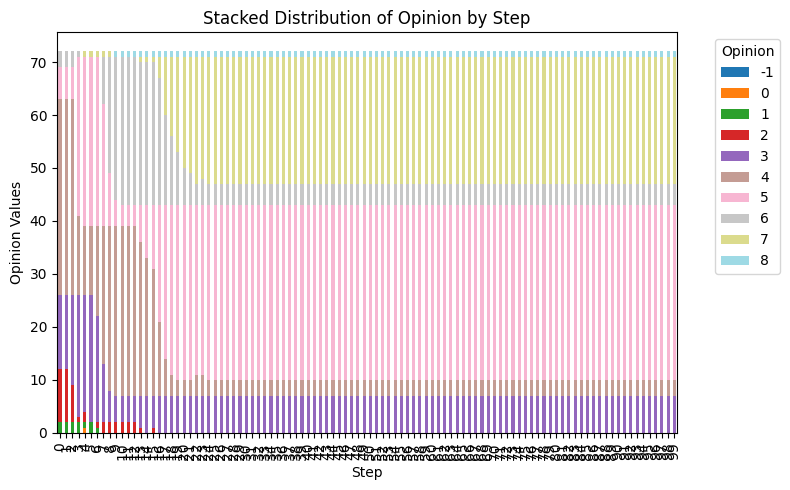

In [21]:
# Call the function
plot_stacked_bar(df_summary,
                 step_col='step',
                 opinion_col='best_opinion',
                 opinion_range=range(int(op_min)-1, int(op_max)+1))

In [22]:
def plot_line(xs, ys, xlabel, ylabel, title):
    plt.figure(figsize=(6, 3.5))
    plt.plot(xs, ys, marker='o', linestyle='-', color='C0')
    plt.xticks(xs, xs + 1)  # assuming xs are 0-indexed run_ids
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(alpha=0.25)

    # annotate each point
    for x, y in zip(xs, ys):
        offset = 0.01 * (np.max(ys) - np.min(ys) if np.max(ys)!=np.min(ys) else 1.0)
        yloc = y + offset if y >= 0 else y - offset
        plt.text(x, yloc, f"{y:.3f}", ha='center', va='bottom' if y>=0 else 'top', fontsize=8)

    plt.tight_layout()
    # plt.savefig(save_path)
    plt.show()

In [23]:
xs = np.arange(len(df_summary))
ys = df_summary['reward_best']

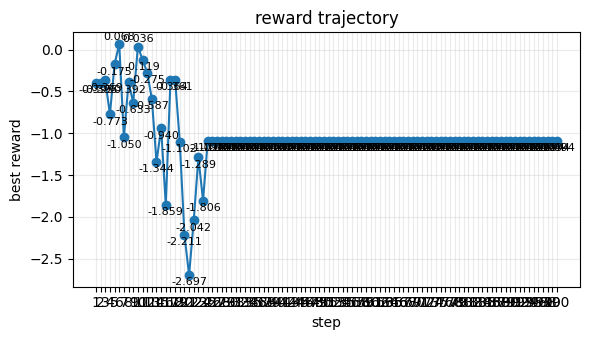

In [24]:
plot_line(xs,ys,
          "step", 'best reward', 'reward trajectory')